# EXPECTED (40%)
### A Convolutional Neural Net (CNN) with 4 Layers

In [68]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#### Import Libraries

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# For loading popular data sets
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

from torch.utils.data.dataloader import DataLoader

### CNN Without Data Augmentation 

#### Preprocessing 

For preprocessing, the first step is the normalization of images based on mean and standard deviation

In [70]:
'''
Normalization - Channel wise mean and standard deviation of the image
'''

# Convert images to Tensor ( Channel X Height X Width)
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.4911, 0.4820, 0.4467),(0.2022, 0.1993, 0.2009))
                             ]) 
                            

# Download training data
train=torchvision.datasets.CIFAR100(root='./data',train=True,download=True,transform=transform)

# Download test data                             
test = torchvision.datasets.CIFAR100(root='./data',train=False,download=True,transform=transform)

# Define validation ratio 
validation_ratio= 0.2
batch_size = 32
train_data,validation_data=torch.utils.data.random_split(train,[int((1-validation_ratio)*len(train)), int((validation_ratio)*len(train))])
print(len(train_data))
print(len(validation_data))

train_loader = DataLoader(train_data, batch_size,pin_memory=True)
val_loader = DataLoader(validation_data, batch_size,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=100,shuffle=False,pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
40000
10000


#### 2. Move to GPU

In [71]:
# Check if your system has cuda gpu or only cpu

def check_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to transfer from CPU to GPU
def move_device(tensor, device):
    
    # Move all individual tensors from cpu to gpu
    if isinstance(tensor, (list,tuple)):
        return [move_device(element, device) for element in tensor]
    return tensor.to(device, non_blocking=True) 

# Execute transfer from CPU to GPU for each device
class DeviceDataLoader():
    
    # Define Constructor
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        
       # Transfer each batch and return
        for i in self.dl: 
            yield move_device(i, self.device)

    def __len__(self):
        
        # Return the number of batches
        return len(self.dl)


device = check_device()

# Move all the tensors to GPU
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)

#### 3. CNN without Data Augmentation and Regularization

In [72]:
class convnet_no_dropout(nn.Module):
    # Constructor
    def __init__(self):
        super(convnet_no_dropout, self).__init__()
        '''
         Convolutional layers
         Conv2d (input channels, output channels, kernel_size, padding) 

        Each Sequential layer has :
              1. A Convolutional Layer
              2. Relu activation function
              3. Maxpool layer
        '''

        self.conv_layer_1 = torch.nn.Sequential(
            # Convoolutional layer
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size= 3,stride=1, padding=1),
            
            # Activation function
            nn.ReLU(),

            # Max pooling layer
            torch.nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_layer_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )


        self.conv_layer_3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_layer_4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
    
        
        # Fully Connected layers
        self.hidden_layer = nn.Linear(128*2*2, 206)
        self.output_layer = nn.Linear(206, 100)
        
    def forward(self, ip):

        # Calling all the convolutional layers
        output = self.conv_layer_1(ip)
        output = self.conv_layer_2(output)
        output = self.conv_layer_3(output)
        output = self.conv_layer_4(output)
        
        # Flattening 
        output = output.view(-1, 128*2*2)
        
        # Call fully connected layer
        output = self.hidden_layer(output)
        
        output=self.output_layer(output)
   
        return output

model1 = convnet_no_dropout()
print(model1)


convnet_no_dropout(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_layer): Linear(in_features=512, out_features=206, bias=True)
  (output_layer): Linear(in_features=206, out_features=100, bias=True)
)


#### Training

In [73]:
def accuracy(predicted,labels):
    pred, predclassid=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predclassid==labels).item()/len(predicted))


def evaluate(model1,dl,loss_func):
    model1.eval()
    batch_losses, batch_accs=[],[]
    for images,labels in valid_dl:
        #start loop
        with torch.no_grad():
            predicted=model1(images)
        batch_losses.append(loss_func(predicted,labels))
        batch_accs.append(accuracy(predicted,labels))
    epoch_avg_loss=torch.stack(batch_losses).mean().item()
    epoch_avg_acc=torch.stack(batch_accs).mean().item()
    return epoch_avg_loss,epoch_avg_acc

def train(model1,train_dl,valid_dl,epochs, max_lr, loss_func,optim):
    
    # Normal optimizer
    #optimizer=optim(model1.parameters(), max_lr)
    
    # Applying L2 Regularization
    #optimizer=optim(model1.parameters(), max_lr,weight_decay=1e-5)
    
    # For SGD
    optimizer=optim(model1.parameters(), max_lr, momentum=0.9,weight_decay=1e-5)
    
    '''
    Learning Rate Scheduler
    '''
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl))
#     scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5,verbose=True)
#     scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)
    
    results=[]
    for epoch in range(epochs):
        model1.train()
        train_losses=[]
        train_batch_accs=[]
        lrs=[]

        for images, labels in train_dl:
            predicted=model1(images)
            loss=loss_func(predicted,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
          # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_batch_accs.append(accuracy(predicted,labels))
    
        scheduler.step()
        epoch_train_acc=torch.stack(train_batch_accs).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        epoch_avg_loss,epoch_avg_acc=evaluate(model1,valid_dl,loss_func)
        
        results.append({'avg_valid_loss': epoch_avg_loss,
                        'avg_val_acc': epoch_avg_acc,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})
        
        print('Number of epochs:', epoch,'|', 
              'Validation loss :',epoch_avg_loss, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',epoch_avg_acc)
    return results


model1=move_device(model1,device)
epochs = 5

'''
Learning Rates
'''
max_lr1 = 1e-1
max_lr2 = 1e-2
max_lr3 = 1e-3
max_lr4 = 1e-4

loss_func=nn.functional.cross_entropy

'''
Optimizers
'''
#optim=torch.optim.Adam
optim=torch.optim.SGD

'''
Train function call
'''
results1= train(model1,train_dl,valid_dl,epochs, max_lr1, loss_func,optim)
results2= train(model1,train_dl,valid_dl,epochs, max_lr2, loss_func,optim)
results3= train(model1,train_dl,valid_dl,epochs, max_lr3, loss_func,optim)
results4= train(model1,train_dl,valid_dl,epochs, max_lr4, loss_func,optim)

Number of epochs: 0 | Validation loss : 3.6175570487976074  | Training loss : 4.070883274078369  |   Training accuracy: 0.07625000178813934 validation accuracy : 0.13678115606307983
Number of epochs: 1 | Validation loss : 3.138268232345581  | Training loss : 3.3063557147979736  |   Training accuracy: 0.19932499527931213 validation accuracy : 0.23562300205230713
Number of epochs: 2 | Validation loss : 2.868253231048584  | Training loss : 2.900676965713501  |   Training accuracy: 0.2732999920845032 validation accuracy : 0.2831469774246216
Number of epochs: 3 | Validation loss : 2.8691365718841553  | Training loss : 2.6364758014678955  |   Training accuracy: 0.32747501134872437 validation accuracy : 0.2890375256538391
Number of epochs: 4 | Validation loss : 2.822669267654419  | Training loss : 2.4536292552948  |   Training accuracy: 0.36410000920295715 validation accuracy : 0.3078075051307678
Number of epochs: 0 | Validation loss : 2.579652786254883  | Training loss : 1.91805899143219  | 

# EXPECTED (40%)
####  Results and visualization

In [75]:
'''
Training Accuracy
'''
avg_training_accuracy1=[]
for result in results1:
    avg_training_accuracy1.append(result['avg_train_acc'])

avg_training_accuracy2=[]
for result in results2:
    avg_training_accuracy2.append(result['avg_train_acc'])
    
avg_training_accuracy3=[]
for result in results3:
    avg_training_accuracy3.append(result['avg_train_acc'])
    
avg_training_accuracy4=[]
for result in results4:
    avg_training_accuracy4.append(result['avg_train_acc'])
    

'''
Validation Accuracy
'''
avg_validation_accuracy1=[]
for result in results1:
    avg_validation_accuracy1.append(result['avg_val_acc'])
avg_validation_accuracy2=[]
for result in results2:
    avg_validation_accuracy2.append(result['avg_val_acc'])
avg_validation_accuracy3=[]
for result in results3:
    avg_validation_accuracy3.append(result['avg_val_acc'])
avg_validation_accuracy4=[]
for result in results4:
    avg_validation_accuracy4.append(result['avg_val_acc'])

'''
Validation Loss
'''
avg_validation_loss1=[]
for result in results1:
    avg_validation_loss1.append(result['avg_valid_loss'])
    
avg_validation_loss2=[]
for result in results2:
    avg_validation_loss2.append(result['avg_valid_loss'])
    
avg_validation_loss3=[]
for result in results3:
    avg_validation_loss3.append(result['avg_valid_loss'])
    
avg_validation_loss4=[]
for result in results4:
    avg_validation_loss4.append(result['avg_valid_loss'])


'''
Training Loss
'''
avg_training_loss1=[]
for result in results1:
    avg_training_loss1.append(result['avg_train_loss'])

avg_training_loss2=[]
for result in results2:
    avg_training_loss2.append(result['avg_train_loss'])
    
avg_training_loss3=[]
for result in results3:
    avg_training_loss3.append(result['avg_train_loss'])

avg_training_loss4=[]
for result in results4:
    avg_training_loss4.append(result['avg_train_loss'])

'''
Epochs count
'''
epoch_count=[]
for i in range(epochs):
    epoch_count.append(i)

# BASIC (40%)
#### Find Max Learning Rate using Graph for Validation Loss/ epoch for Different Learning Rates

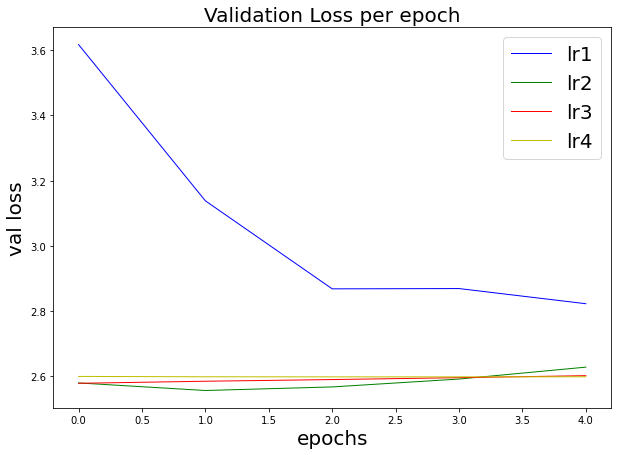

In [76]:
figure(figsize=(10,7))
plt.plot(epoch_count,avg_validation_loss1, 'b', label = "lr1",linewidth = '1')
plt.plot(epoch_count,avg_validation_loss2, 'g', label = "lr2", linewidth = '1')
plt.plot(epoch_count,avg_validation_loss3, 'r', label = "lr3", linewidth = '1')
plt.plot(epoch_count,avg_validation_loss4, 'y', label = "lr4", linewidth = '1')
plt.title("Validation Loss per epoch",fontsize=20)
plt.xlabel("epochs",fontsize=20)  
plt.ylabel("val loss",fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Graph for Training Loss/epoch for Different Learning Rates

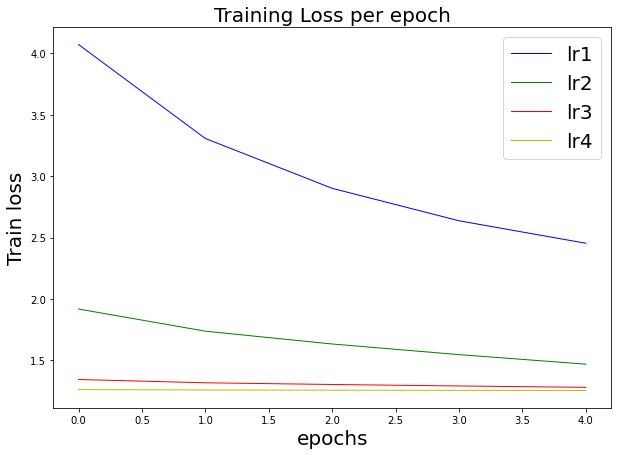

In [77]:
figure(figsize=(10,7))
plt.plot(epoch_count,avg_training_loss1, 'b', label = "lr1",linewidth = '1')
plt.plot(epoch_count,avg_training_loss2, 'g', label = "lr2", linewidth = '1')
plt.plot(epoch_count,avg_training_loss3, 'r', label = "lr3", linewidth = '1')
plt.plot(epoch_count,avg_training_loss4, 'y', label = "lr4", linewidth = '1')
plt.title("Training Loss per epoch",fontsize=20)
plt.xlabel("epochs",fontsize=20)  
plt.ylabel("Train loss",fontsize=20)
plt.legend(fontsize=20)
plt.show()

#### Graph for Accuracy per epoch

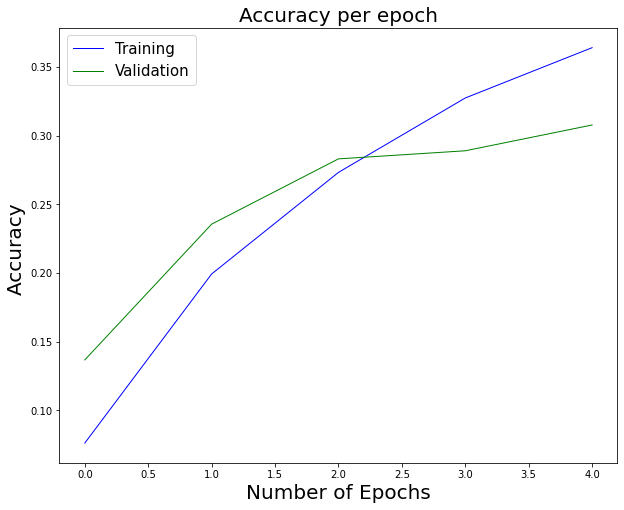

In [78]:
figure(figsize=(10,8))
plt.plot(epoch_count,avg_training_accuracy1, 'blue', label = "Training", linewidth = '1')
plt.plot(epoch_count,avg_validation_accuracy1, 'green', label = "Validation", linewidth = '1')
plt.title("Accuracy per epoch",fontsize=20)
plt.xlabel("Number of Epochs",fontsize=20)  
plt.ylabel("Accuracy ",fontsize=20)
plt.legend(fontsize=15)
plt.show()

#### Test Accuracy

In [80]:
def accuracy(predicted,labels):
    pred, predclassid=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predclassid==labels).item()/len(predicted))

def evaluate(model1,dl,loss_func):
    model1.eval()
    batch_losses, batch_accs=[],[]
    for images,labels in valid_dl:
        with torch.no_grad():
            predicted=model1(images)
        batch_losses.append(loss_func(predicted,labels))
        batch_accs.append(accuracy(predicted,labels))
    epoch_avg_loss=torch.stack(batch_losses).mean().item()
    epoch_avg_acc=torch.stack(batch_accs).mean().item()
    return epoch_avg_loss,epoch_avg_acc

def train(model1,train_dl,valid_dl,epochs, max_lr, loss_func,optim):  
    optimizer=optim(model1.parameters(), max_lr)
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl))    
    results=[]
    for epoch in range(epochs):
        model1.train()
        train_losses=[]
        train_batch_accs=[]
        lrs=[]
        for images, labels in train_dl:
            predicted=model1(images)
            loss=loss_func(predicted,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(optimizer.param_groups[0]['lr'])
            train_batch_accs.append(accuracy(predicted,labels))
        scheduler.step()
        epoch_train_acc=torch.stack(train_batch_accs).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        epoch_avg_loss,epoch_avg_acc=evaluate(model1,valid_dl,loss_func)
        results.append({'avg_valid_loss': epoch_avg_loss,
                        'avg_val_acc': epoch_avg_acc,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})
    return results

model1=move_device(model1,device)
epochs = 5
max_lr = 1e-1
loss_func=nn.functional.cross_entropy
optim=torch.optim.SGD
results= train(model1,train_dl,valid_dl,epochs, max_lr, loss_func,optim)

_,test_acc=evaluate(model1, test_dl, loss_func)
print('Test Accuracy without Data Augmentation and Dropout : ', test_acc)

Test Accuracy without Data Augmentation and Dropout :  0.2836461663246155


# Expected (40%)
#### CNN With Data Augmentation and Regularization 

In [35]:
class convnet_dropout(nn.Module):
    # Constructor
    def __init__(self):
        super(convnet_dropout, self).__init__()
        '''
         Convolutional layers
         Conv2d (input channels, output channels, kernel_size, padding) 

        Each Sequential layer has :
              1. A Convolutional Layer
              2. Relu activation function
              3. Maxpool layer
        '''

        self.conv_layer_1 = torch.nn.Sequential(
            # Convoolutional layer
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size= 3,stride=1, padding=1),
            
            # Activation function
            nn.ReLU(),

            # Max pooling layer
            torch.nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_layer_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )


        self.conv_layer_3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        
        self.conv_layer_4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
    
        
        # Fully Connected layers
        self.hidden_layer = nn.Linear(128*2*2, 206)
        self.dropout_layer=nn.Dropout(p=0.25)
        self.output_layer = nn.Linear(206, 100)
        
    def forward(self, ip):

        # Calling all the convolutional layers
        output = self.conv_layer_1(ip)
        output = self.conv_layer_2(output)
        output = self.conv_layer_3(output)
        output = self.conv_layer_4(output)
        
        # Flattening 
        output = output.view(-1, 128*2*2)
        
        # Call fully connected layer
        output = self.hidden_layer(output)
        output=self.output_layer(output)
   
        return output

model1 = convnet_dropout()
print(model1)


convnet_dropout(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (hidden_layer): Linear(in_features=512, out_features=206, bias=True)
  (dropout_layer): Dropout(p=0.25, inplace=False)
  (output_layer): Linear(i

#### Training

In [36]:
transform=transforms.Compose([transforms.RandomCrop(32, padding=4,padding_mode='reflect'), 
                              transforms.ToTensor(),  # Convert images to Tensor ( Channel X Height X Width)
                                transforms.Normalize((0.4911, 0.4820, 0.4467),(0.2022, 0.1993, 0.2009)) 
                             ])

# Download training data
train = torchvision.datasets.CIFAR100(root='./data',train=True,download=True,transform=transform)


# Download test data                             
test = torchvision.datasets.CIFAR100(root='./data',train=False,download=True)



from torch.utils.data.dataloader import DataLoader
 
 # Define validation ratio 
validation_ratio= 0.2
batch_size = 32

# split training data in train and validation set
train_data,validation_data=torch.utils.data.random_split(train,[int((1-validation_ratio)*len(train)), 
                                              int((validation_ratio)*len(train))])

print(len(train_data))
print(len(validation_data))

train_loader = DataLoader(train_data, batch_size,pin_memory=True)
val_loader = DataLoader(validation_data, batch_size,pin_memory=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=100,shuffle=False,pin_memory=True)
                                          
                                          
# Check if your system has cuda gpu or only cpu

def check_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to transfer from CPU to GPU
def move_device(tensor, device):
    
    # Move all individual tensors from cpu to gpu
    if isinstance(tensor, (list,tuple)):
        return [move_device(element, device) for element in tensor]
    return tensor.to(device, non_blocking=True) 

# Execute transfer from CPU to GPU for each device
class DeviceDataLoader():
    
    # Define Constructor
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device
        
    def __iter__(self):
        
       # Transfer each batch and return
        for i in self.dl: 
            yield move_device(i, self.device)

    def __len__(self):
        
        # Return the number of batches
        return len(self.dl)


device = check_device()

# Move all the tensors to GPU
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)
test_dl = DeviceDataLoader(test_loader, device)


def accuracy(predicted,labels):
    pred, predclassid=torch.max(predicted,dim=1)
    return torch.tensor(torch.sum(predclassid==labels).item()/len(predicted))


def evaluate(model1,dl,loss_func):
    model1.eval()
    batch_losses, batch_accs=[],[]
    for images,labels in valid_dl:
        #start loop
        with torch.no_grad():
            predicted=model1(images)
        batch_losses.append(loss_func(predicted,labels))
        batch_accs.append(accuracy(predicted,labels))
    epoch_avg_loss=torch.stack(batch_losses).mean().item()
    epoch_avg_acc=torch.stack(batch_accs).mean().item()
    return epoch_avg_loss,epoch_avg_acc

def train(model1,train_dl,valid_dl,epochs, max_lr, loss_func,optim):
    
    # Normal optimizer
#     optimizer=optim(model1.parameters(), max_lr)
    
    # Applying L2 Regularization
    optimizer=optim(model1.parameters(), max_lr,weight_decay=1e-5)
    
    # For SGD
    #optimizer=optim(model1.parameters(), max_lr, momentum=0.9,weight_decay=1e-5)
    
    '''
    Learning Rate Scheduler
    '''
    scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl))
#     scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5,verbose=True)
#     #scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.9)
    
    results=[]
    for epoch in range(epochs):
        model1.train()
        train_losses=[]
        train_batch_accs=[]
        lrs=[]

        for images, labels in train_dl:
            predicted=model1(images)
            loss=loss_func(predicted,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
          # keep track of learning rate
            lrs.append(optimizer.param_groups[0]['lr'])
            train_batch_accs.append(accuracy(predicted,labels))
    
        scheduler.step()
        epoch_train_acc=torch.stack(train_batch_accs).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        epoch_avg_loss,epoch_avg_acc=evaluate(model1,valid_dl,loss_func)
        
        results.append({'avg_valid_loss': epoch_avg_loss,
                        'avg_val_acc': epoch_avg_acc,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})
        
        print('Number of epochs:', epoch,'|', 
              'Validation loss :',epoch_avg_loss, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',epoch_avg_acc)
    return results


model1=move_device(model1,device)
epochs = 40

'''
Learning Rates
'''
max_lr1 = 1e-1


loss_func=nn.functional.cross_entropy

'''
Optimizers
'''
#optim=torch.optim.Adam
optim=torch.optim.SGD

'''
Train function call
'''
results1= train(model1,train_dl,valid_dl,epochs, max_lr1, loss_func,optim)

Files already downloaded and verified
Files already downloaded and verified
40000
10000
Number of epochs: 0 | Validation loss : 3.7693183422088623  | Training loss : 4.159159183502197  |   Training accuracy: 0.06377500295639038 validation accuracy : 0.10603035241365433
Number of epochs: 1 | Validation loss : 3.3568718433380127  | Training loss : 3.5079357624053955  |   Training accuracy: 0.16304999589920044 validation accuracy : 0.18390575051307678
Number of epochs: 2 | Validation loss : 3.122643232345581  | Training loss : 3.171964406967163  |   Training accuracy: 0.22417500615119934 validation accuracy : 0.23132987320423126
Number of epochs: 3 | Validation loss : 2.957852602005005  | Training loss : 2.936441421508789  |   Training accuracy: 0.26797500252723694 validation accuracy : 0.26357826590538025
Number of epochs: 4 | Validation loss : 2.840482473373413  | Training loss : 2.793203353881836  |   Training accuracy: 0.2946999967098236 validation accuracy : 0.2835463285446167
Number

### EXPECTED (40%)
#### Visualizations

In [37]:
'''
Training Accuracy
'''
avg_training_accuracy1=[]
for result in results1:
    avg_training_accuracy1.append(result['avg_train_acc']*100)

avg_training_accuracy2=[]
for result in results2:
    avg_training_accuracy2.append(result['avg_train_acc']*100)
    
avg_training_accuracy3=[]
for result in results3:
    avg_training_accuracy3.append(result['avg_train_acc']*100)
    
avg_training_accuracy4=[]
for result in results4:
    avg_training_accuracy4.append(result['avg_train_acc']*100)
    

'''
Validation Accuracy
'''
avg_validation_accuracy1=[]
for result in results1:
    avg_validation_accuracy1.append(result['avg_val_acc']*100)
avg_validation_accuracy2=[]
for result in results2:
    avg_validation_accuracy2.append(result['avg_val_acc']*100)
avg_validation_accuracy3=[]
for result in results3:
    avg_validation_accuracy3.append(result['avg_val_acc']*100)
avg_validation_accuracy4=[]
for result in results4:
    avg_validation_accuracy4.append(result['avg_val_acc']*100)

'''
Validation Loss
'''
avg_validation_loss1=[]
for result in results1:
    avg_validation_loss1.append(result['avg_valid_loss'])
    
avg_validation_loss2=[]
for result in results2:
    avg_validation_loss2.append(result['avg_valid_loss'])
    
avg_validation_loss3=[]
for result in results3:
    avg_validation_loss3.append(result['avg_valid_loss'])
    
avg_validation_loss4=[]
for result in results4:
    avg_validation_loss4.append(result['avg_valid_loss'])


'''
Training Loss
'''
avg_training_loss1=[]
for result in results1:
    avg_training_loss1.append(result['avg_train_loss'])

avg_training_loss2=[]
for result in results2:
    avg_training_loss2.append(result['avg_train_loss'])
    
avg_training_loss3=[]
for result in results3:
    avg_training_loss3.append(result['avg_train_loss'])

avg_training_loss4=[]
for result in results4:
    avg_training_loss4.append(result['avg_train_loss'])

'''
Epochs count
'''
epoch_count=[]
for i in range(epochs):
    epoch_count.append(i)

# ADVANCED (20%)
#### Results : Accuracy vs Epochs

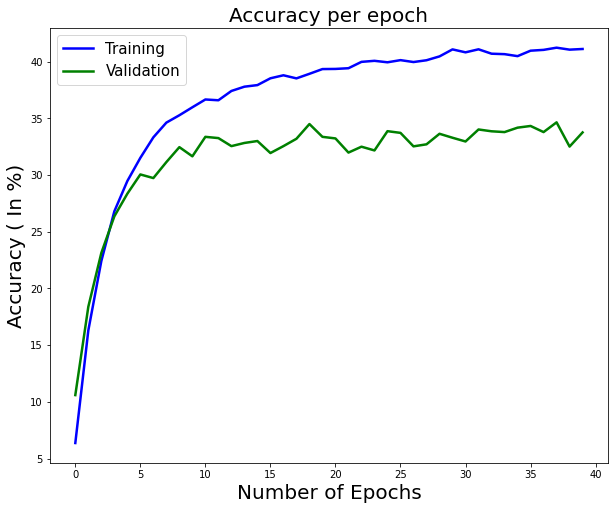

In [38]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.colors as colors

figure(figsize=(10,8))
plt.plot(epoch_count,avg_training_accuracy1, 'b-', label = "Training", linewidth = '2.5',markersize=8)
plt.plot(epoch_count,avg_validation_accuracy1, 'green', label = "Validation", linewidth = '2.5',markersize=8)
plt.title("Accuracy per epoch",fontsize=20)
plt.xlabel("Number of Epochs",fontsize=20)  
plt.ylabel("Accuracy ( In %)",fontsize=20)

plt.legend(fontsize=15)
plt.show()

#### Test Accuracy with Data Augmentation and Dropout

In [39]:
model2=convnet_dropout()
_,test_acc=evaluate(model1, test_dl, loss_func)
print('Test Accuracy : ', test_acc*100,' %')


Test Accuracy :  33.42651724815369  %
